In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.utils import data

In [0]:
graphs = np.load("graph_10+20k.npy")
# options: graph_10+20k, graph_10+10k
labels = np.load("labels_10+20k.npy")
# options: labels_10+20k, labels_10+10k

In [31]:
num_of_graphs = graphs.shape[0]
num_of_nodes = graphs.shape[1]


def compress_graphs(graphs):
    """Convert 3d matrix of graphs, dims = (graphs,verts,verts), 
    to 2d matrix dims = (n_graphs, (verts choose 2) - verts). 
    We can omit half of the data as the matrix of each graph is 
    symmetric as we are working with undirected graphs. We can
    also not take any entries on the main diagonal as they will 
    always be zero as we do not allow self loops.
    
    
    Args: 
        graphs : (n_graphs,verts,verts) hypermatrix of graphs.
        
    Returns:
        graphs_comp : (n_graphs, (vert choose 2) - verts) matrix
            of compressed adjancey matrices.
        
        
    """
    
    verts = graphs.shape[1]
    graphs_comp =  graphs.T[np.triu_indices(verts, 1)].T
    
    return graphs_comp  

# compress 2d adjacency matrix to 1d array, prepare input
compressed_graph = np.zeros((graphs.shape[0], int(num_of_nodes*(num_of_nodes-1)/2)))
                            
for i in range(0,graphs.shape[0]):
    compressed_graph[i] = compress_graphs(graphs[i])

graphs_train, graphs_test, train_labels, val_labels =\
    train_test_split(compressed_graph, labels, test_size=0.20, random_state=42)

batch_size = 64
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return num_of_graphs

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = index

        # Load data and get label
        X = Variable(torch.from_numpy(compressed_graph[ID]))
        y = self.labels[ID]

        return X, y

# Generators
training_set = Dataset(graphs_train, labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(graphs_test, labels)
validation_generator = data.DataLoader(validation_set, **params)

class CompressMatrixNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        u = int(num_of_nodes*(num_of_nodes-1)/2)
        self.fc1 = nn.Linear(u, 2*u)
        self.fc3 = nn.Linear(2*u, 85)
        self.fc4 = nn.Linear(85, 40)
        self.fc5 = nn.Linear(85, 40)
        self.fc6 = nn.Linear(40, num_of_nodes)
        self.fc7 = nn.Linear(40, num_of_nodes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x1 = F.relu(self.fc4(x))
        x1 = self.fc6(x1)
        x2 = F.relu(self.fc5(x))
        x2 = self.fc7(x2)
        return F.softmax(x1, dim=1), F.softmax(x2, dim=1)

model = CompressMatrixNetwork()

for module in model.children():
    module.reset_parameters()

if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer.zero_grad()


info = []
# Loop over epochs
for epoch in range(max_epochs):
    epoch_train_acc, correct_count = 0, 0
    epoch_val_acc = 0
    epoch_train_loss = 0
    epoch_val_loss=0
    count = 0
    
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        if torch.cuda.is_available():
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
        
        model.train()
        
        label_batch = local_labels.long()
        input_batch = local_batch.float()

        output_batch = model(input_batch)

        train_loss = F.cross_entropy(output_batch[0], label_batch[:,0]) \
            + F.cross_entropy(output_batch[1], label_batch[:,1])
        epoch_train_loss += train_loss

        
        pred1 = output_batch[0].data.max(1)[1]
        pred2 = output_batch[1].data.max(1)[1]
        
        matches = (label_batch[:,0] == pred1) & (label_batch[:,1] == pred2)
        epoch_train_acc += matches.float().mean()
        correct_count += matches.sum()
        
        optimizer.zero_grad()
        
        train_loss.backward()
        optimizer.step()
        count += 1
    epoch_train_loss = epoch_train_loss / count
    epoch_train_acc = epoch_train_acc / count
    # Validation
    count = 0
    with torch.no_grad():
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()

            model.eval()
            
            label_batch = local_labels.long()
            input_batch = local_batch.float()
            
            output_batch = model(input_batch)
            
            
            val_loss = F.cross_entropy(output_batch[0], label_batch[:,0]) \
                + F.cross_entropy(output_batch[1], label_batch[:,1])
            epoch_val_loss += val_loss

            pred1 = output_batch[0].data.max(1)[1]
            pred2 = output_batch[1].data.max(1)[1]
            
            matches = (label_batch[:,0] == pred1) & (label_batch[:,1] == pred2)
            epoch_val_acc += matches.float().mean()
            count += 1
        epoch_val_loss = epoch_val_loss / count
        epoch_val_acc = epoch_val_acc / count
    info.append([epoch, epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc])
    print('epoch {:5d}: Obtained a training acc of {:.3f}.'.format(epoch, epoch_train_acc))
    print('epoch {:5d}: Obtained a validation acc of {:.3f}.'.format(epoch, epoch_val_acc))

epoch     0: Obtained a training acc of 0.002.
epoch     0: Obtained a validation acc of 0.002.
epoch     1: Obtained a training acc of 0.003.
epoch     1: Obtained a validation acc of 0.003.
epoch     2: Obtained a training acc of 0.003.
epoch     2: Obtained a validation acc of 0.003.
epoch     3: Obtained a training acc of 0.004.
epoch     3: Obtained a validation acc of 0.004.
epoch     4: Obtained a training acc of 0.010.
epoch     4: Obtained a validation acc of 0.017.
epoch     5: Obtained a training acc of 0.020.
epoch     5: Obtained a validation acc of 0.021.
epoch     6: Obtained a training acc of 0.021.
epoch     6: Obtained a validation acc of 0.022.
epoch     7: Obtained a training acc of 0.023.
epoch     7: Obtained a validation acc of 0.026.
epoch     8: Obtained a training acc of 0.032.
epoch     8: Obtained a validation acc of 0.038.
epoch     9: Obtained a training acc of 0.051.
epoch     9: Obtained a validation acc of 0.067.
epoch    10: Obtained a training acc of 

(0.0, 1.0)

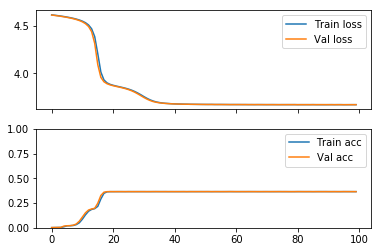

In [32]:
x, y11, y12, y21, y22 = zip(*info)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(x, y11, x, y12)
ax[0].legend(['Train loss', 'Val loss'])
ax[1].plot(x, y21, x, y22)
ax[1].legend(['Train acc', 'Val acc'])
ax[1].set_ylim([0.0, 1.0])